# Desafio 2 - NLP

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.
- Probar términos de interés y explicar similitudes en el espacio de embeddings.
- Intentar plantear y probar tests de analogías. 
- Graficar los embeddings resultantes.
- Sacar conclusiones.

## Imports

In [659]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from gensim.models import Word2Vec
import os
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
import nltk
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np
import plotly.graph_objects as go
import plotly.express as px                   

## Funciones generales

In [660]:
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [661]:
def reduce_dimensions(model, num_dimensions = 2 ):
     
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [662]:
def max_words (model, vecs, labels, highlight_words, MAX_WORDS, topn=10):
    all_words = list(labels)
    selected_words = set(highlight_words)

    for word in highlight_words:
        if word in model.wv:
            try:
                similar = model.wv.most_similar(word, topn=topn)
                selected_words.update([w for w, _ in similar])
            except KeyError:
                pass  # por si alguna palabra no está en vocabulario

    for word in all_words:
        if len(selected_words) >= MAX_WORDS:
            break
        if word not in selected_words:
            selected_words.add(word)

    selected_words = list(selected_words)
    indices = [all_words.index(w) for w in selected_words if w in all_words]
    filtered_vecs = vecs[indices]
    filtered_labels = [all_words[i] for i in indices]
    return filtered_vecs, filtered_labels

In [663]:
def plot_embeddings(model, vecs, labels, MAX_WORDS=200, highlight_words=None):
    assert vecs.shape[0] == len(labels), "Vecs y labels deben tener la misma longitud"
    vecs, labels = max_words(model, vecs, labels, highlight_words, MAX_WORDS)
    # Colores: rojo si está en highlight, azul si no
    highlight_words = set(highlight_words) if highlight_words else set()
    colors = ['red' if word in highlight_words else 'blue' for word in labels]

    if vecs.shape[1] == 2:
        fig = px.scatter(
            x=vecs[:, 0],
            y=vecs[:, 1],
            text=labels,
            color=colors,
            labels={"color": "Tipo de palabra"}
        )
    elif vecs.shape[1] == 3:
        fig = px.scatter_3d(
            x=vecs[:, 0],
            y=vecs[:, 1],
            z=vecs[:, 2],
            text=labels,
            color=colors,
            labels={"color": "Tipo de palabra"}
        )
        fig.update_traces(marker_size = 2)
    else:
        raise ValueError("Los vectores deben ser de dimensión 2 o 3")

    fig.update_traces(textposition='top center')
    fig.show()

In [664]:
def embeddings_matrix_distance(model, words, extra_vector=None, extra_label="nuevo"):
    emb = np.array([model.wv.get_vector(word) for word in words])
    if extra_vector is not None:
        emb = np.vstack([emb, extra_vector])
        words = words + [extra_label]
    dist = cosine_similarity(emb, emb)
    plot_matrix_distance(words, dist)


def plot_matrix_distance(words, dist):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    sns.heatmap(dist, xticklabels=words, yticklabels=words, 
                annot=True, fmt=".2f", cmap="YlGnBu", ax=ax, mask=np.triu(dist))
    plt.show()

## Preprocesamiento

In [665]:
os.listdir("corpus")

['Indiana_Jones_And_The_Last_Crusade.txt',
 'Indiana_Jones_And_The_Temple_Of_Doom.txt',
 'Raiders_Of_The_Lost_Ark.txt']

In [666]:
df1 = pd.read_csv('corpus/Indiana_Jones_And_The_Last_Crusade.txt', sep='/n', header=None, engine='python')
df2 = pd.read_csv('corpus/Raiders_Of_The_Lost_Ark.txt', sep='/n', header=None, engine='python')
df3 = pd.read_csv('corpus/Indiana_Jones_And_The_Temple_Of_Doom.txt', sep='/n', header=None, engine='python')
df = pd.concat([df1, df2, df3], ignore_index=True)
display(df.head())
display("Cantidad de documentos:", df.shape[0])

,0
0,"""INDIANA JONES AND THE LAST CRUSADE"""
1,Screenplay by
2,Jeffrey Boam
3,FADE IN:
4,EXT. DESERT OF THE AMERICAN SOUTHWEST - DAY


'Cantidad de documentos:'

13504

In [667]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

sentence_tokens = []
for _, row in df[:None].iterrows():
    tokens = text_to_word_sequence(row[0])  # Tokenizar con Keras
    filtered_tokens = [word for word in tokens if word not in stop_words]
    sentence_tokens.append(filtered_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pablo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Crear los vectores (word2vec)

In [668]:
w2v_model = Word2Vec(min_count=4,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=10,       # cant de palabras antes y desp de la predicha
                     vector_size=384, # dimensionalidad de los vectores 
                     negative=25,    # cantidad de negative samples... 0 es no se usa
                     workers=4,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [669]:
w2v_model.build_vocab(sentence_tokens)
display("Cantidad de docs en el corpus:", w2v_model.corpus_count)
display("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

'Cantidad de docs en el corpus:'

13504

'Cantidad de words distintas en el corpus:'

2214

In [670]:
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=70,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 249454.828125
Loss after epoch 1: 156733.296875
Loss after epoch 2: 149225.6875
Loss after epoch 3: 147198.5
Loss after epoch 4: 146100.0625
Loss after epoch 5: 143444.875
Loss after epoch 6: 131428.75
Loss after epoch 7: 123197.375
Loss after epoch 8: 125485.0
Loss after epoch 9: 118460.25
Loss after epoch 10: 117426.625
Loss after epoch 11: 115814.25
Loss after epoch 12: 112132.0
Loss after epoch 13: 110374.25
Loss after epoch 14: 107018.125
Loss after epoch 15: 100967.375
Loss after epoch 16: 94553.5
Loss after epoch 17: 93438.75
Loss after epoch 18: 91549.5
Loss after epoch 19: 89957.5
Loss after epoch 20: 89218.25
Loss after epoch 21: 86787.75
Loss after epoch 22: 85857.25
Loss after epoch 23: 82931.0
Loss after epoch 24: 83248.5
Loss after epoch 25: 81437.25
Loss after epoch 26: 80368.0
Loss after epoch 27: 78384.25
Loss after epoch 28: 77795.0
Loss after epoch 29: 76838.5
Loss after epoch 30: 75096.0
Loss after epoch 31: 75069.75
Loss after epoch 32: 73622.25

(2518786, 3386040)

## Pruebas

In [671]:
w2v_model.wv.most_similar(positive=["grail"], topn=10)

[('diary', 0.5241427421569824),
 ('attempt', 0.5012202262878418),
 ('pages', 0.4930433928966522),
 ('sinister', 0.4870297610759735),
 ('knight', 0.4811377227306366),
 ('page', 0.4804885685443878),
 ('forget', 0.47650742530822754),
 ('seal', 0.4636004865169525),
 ('complete', 0.456119179725647),
 ('america', 0.44103026390075684)]

En este caso podemos ver como la palabra que mas correlación tiene con Grial es Diario, en la pelicula "Indiana Jones y la última cruzada", se menciona varias veces al diario del grial donde estaba la información de como encontrarlo. 

In [672]:
w2v_model.wv.most_similar(positive=["ark"], topn=10)

[('covenant', 0.553375780582428),
 ('poles', 0.5010483860969543),
 ('crated', 0.49781620502471924),
 ('lid', 0.4494187533855438),
 ('rod', 0.4197686016559601),
 ('message', 0.38662293553352356),
 ('shut', 0.38425305485725403),
 ('arrives', 0.3800394833087921),
 ('tightly', 0.37859854102134705),
 ('means', 0.3718227446079254)]

En "Indiana Jones y los cazadores del arca perdida" la famosa arca se llama "el arca de la alianza" por eso la mejor correlación es con esa palabra.

In [673]:
w2v_model.wv.most_similar(positive=["sankara"], topn=10)

[('stones', 0.718417763710022),
 ('stolen', 0.6519231796264648),
 ('sacred', 0.6461431980133057),
 ('bag', 0.604703426361084),
 ('magical', 0.5736081004142761),
 ('jai', 0.5678609609603882),
 ('brothers', 0.5602326393127441),
 ('gave', 0.5539853572845459),
 ('goddess', 0.5538668632507324),
 ('stole', 0.531678318977356)]

En "Indiana Jones y el templo de la pedición" el objeto que Indy debe rescatar era la Piedra de Sankara, que eran unas piedras sagradas.

In [674]:
w2v_model.wv.most_similar(negative=["boulder"], topn=10)

[('interrupting', 0.05359134078025818),
 ('makes', 0.048473015427589417),
 ('overlapping', 0.041112739592790604),
 ('subtitled', 0.040371742099523544),
 ('maybe', 0.020450284704566002),
 ('matter', 0.01541290245950222),
 ('drinks', 0.004645785316824913),
 ('sinister', -0.002820732071995735),
 ('mail', -0.003089320380240679),
 ('opening', -0.007235695142298937)]

Para la relación inversa no es que se detecten antonimos, sino palabras que no estan muy relacionadas en el espacio del embedding. No podemos sacar mucha conclusión del ejemplo.

In [679]:
w2v_model.wv.doesnt_match(["Indiana","Jones","Indy","snakes"])

'snakes'

## Visualizar agrupación de vectores

In [675]:
vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=500
plot_embeddings(w2v_model, vecs, labels, MAX_WORDS, highlight_words=["grail","ark","sankara"])

In [680]:
vecs, labels = reduce_dimensions(w2v_model,3)

MAX_WORDS=200
plot_embeddings(w2v_model, vecs, labels, MAX_WORDS, highlight_words=["grail","ark","sankara"])

### Test de analogía

[('christ', 0.43132275342941284),
 ('complete', 0.42349615693092346),
 ('glory', 0.4203645586967468),
 ('somewhere', 0.3896515667438507),
 ('fortune', 0.376832515001297),
 ('knee', 0.3557438254356384),
 ('america', 0.3541530966758728),
 ('embrace', 0.3423731327056885)]

0.43132272

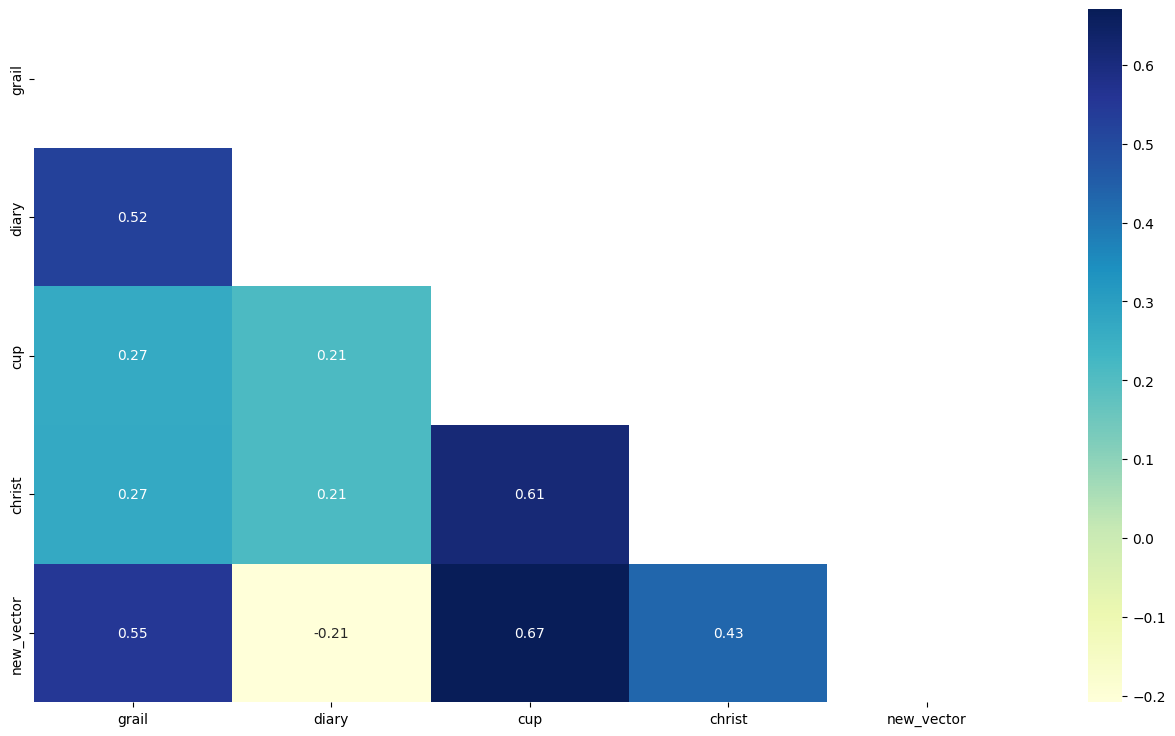

In [677]:
words = ["grail","diary","cup"]
vector1 = w2v_model.wv.get_vector(words[0])
vector2 = w2v_model.wv.get_vector(words[1])
vector3 = w2v_model.wv.get_vector(words[2])

new_vector = vector1 - vector2 + vector3

display(w2v_model.wv.most_similar(new_vector)[2:])
display(cosine_similarity([new_vector], [w2v_model.wv.get_vector("christ")])[0][0])
words.append("christ")
embeddings_matrix_distance(w2v_model, words, new_vector, "new_vector")

Se intentó hacer el test de analogía con referirise al Santo Grial como la copa y no como el diario, la correlación no es muy fuerte, pero dentro de lo mas próximo tenemos a Cristo.

In [ ]:
# Otro metodo
w2v_model.wv.most_similar(positive=["grail","cup"], negative=["diary"])

[('christ', 0.4667717218399048),
 ('glory', 0.4564523696899414),
 ('complete', 0.43824461102485657),
 ('somewhere', 0.4177197813987732),
 ('fortune', 0.3977448642253876),
 ('knee', 0.37022218108177185),
 ('america', 0.3701187074184418),
 ('embrace', 0.36896124482154846),
 ('country', 0.36145535111427307),
 ('caught', 0.359525203704834)]